In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from ipywidgets import IntSlider, HBox, interactive_output
import ipywidgets as widgets
import os
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import skew, kurtosis
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as sns
from functools import reduce
import talib

from utils import *

In [2]:
# Load data
data_path = os.path.dirname(os.getcwd()) + '/data'
data_file = data_path + '/fpi_raw_data.xlsx'
data = pd.read_excel(data_file, sheet_name='Universe of broad assets', index_col=0, parse_dates=True)

# Initial Visualizations

In [3]:
def plot_histogram(series, bin_width, start_date, end_date):
    # Filter data by selected date range and series
    series_data = data[series]
    if start_date and end_date:
        filtered_data = series_data[(series_data.index >= pd.to_datetime(start_date)) & 
                                    (series_data.index <= pd.to_datetime(end_date))]
    else:
        filtered_data = series_data
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_data.dropna(), bins=bin_width, edgecolor='black')
    plt.title(f'Histogram of {series}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

def summary_table(series, start_date, end_date):
    # Filter data by selected date range and series
    series_data = data[series]
    if start_date and end_date:
        filtered_data = series_data[(series_data.index >= pd.to_datetime(start_date)) & 
                                    (series_data.index <= pd.to_datetime(end_date))]
    else:
        filtered_data = series_data
        
    # Display summary statistics
    stats = {
        'Count': filtered_data.count(),
        'Mean': filtered_data.mean(),
        'Standard Deviation': filtered_data.std(),
        'Skewness': skew(filtered_data.dropna()),
        'Kurtosis': kurtosis(filtered_data.dropna()),
        'Minimum': filtered_data.min(),
        'Maximum': filtered_data.max()
    }
    
    # Print stats in a table format
    stats_df = pd.DataFrame(stats, index=[0]).T.rename(columns={0: 'Value'})
    display(stats_df)

In [4]:
# Widget controls
series_selector = widgets.Dropdown(options=data.columns, description='Series')
bin_slider = widgets.IntSlider(value=50, min=10, max=100, description='Bin Count')
start_date_picker = widgets.DatePicker(description='Start Date')
end_date_picker = widgets.DatePicker(description='End Date')

# Display widgets
controls = widgets.HBox([series_selector, bin_slider, start_date_picker, end_date_picker])

# Interactive plot output
out1 = widgets.interactive_output(plot_histogram, {
    'series': series_selector,
    'bin_width': bin_slider,
    'start_date': start_date_picker,
    'end_date': end_date_picker
})

out2 = widgets.interactive_output(summary_table, {
    'series': series_selector,
    'start_date': start_date_picker,
    'end_date': end_date_picker
})

ui = widgets.VBox([controls, out1])
widgets.HBox([ui, out2])


# Aggregating Returns up to Weekly

In [5]:
broad_assets = data.copy()
broad_assets.head()

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,0.0152,0.0757,-0.0023,0.0009,0.0422,0.0050,0.0373,0.0021,-0.0025,-0.0084,-0.0318
2000-08-01,0.0099,-0.0491,0.0079,0.0063,-0.0115,0.0404,-0.0292,0.0107,0.0096,0.0005,0.0146
2000-08-02,0.0007,-0.0178,0.0015,0.0037,0.0098,-0.0095,-0.0005,0.0010,0.0112,0.0012,0.0187
2000-08-03,0.0192,0.0761,0.0072,0.0031,-0.0031,-0.0210,-0.0307,-0.0095,0.0061,-0.0262,0.0072
2000-08-04,0.0142,-0.0030,0.0066,0.0062,0.0164,-0.0249,0.0129,0.0042,-0.0012,-0.0036,0.0326


In [6]:
broad_assets.index = pd.to_datetime(broad_assets.index)
broad_assets['weekday'] = broad_assets.index.day_name()
broad_assets.head(10) #['2000-08-27':'2000-09-10']

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11,weekday
Date,,,,,,,,,,,,
2000-07-31,0.0152,0.0757,-0.0023,0.0009,0.0422,0.0050,0.0373,0.0021,-0.0025,-0.0084,-0.0318,Monday
2000-08-01,0.0099,-0.0491,0.0079,0.0063,-0.0115,0.0404,-0.0292,0.0107,0.0096,0.0005,0.0146,Tuesday
2000-08-02,0.0007,-0.0178,0.0015,0.0037,0.0098,-0.0095,-0.0005,0.0010,0.0112,0.0012,0.0187,Wednesday
2000-08-03,0.0192,0.0761,0.0072,0.0031,-0.0031,-0.0210,-0.0307,-0.0095,0.0061,-0.0262,0.0072,Thursday
2000-08-04,0.0142,-0.0030,0.0066,0.0062,0.0164,-0.0249,0.0129,0.0042,-0.0012,-0.0036,0.0326,Friday
2000-08-07,0.0222,0.0504,-0.0073,-0.0060,0.0247,-0.0076,0.0291,-0.0178,-0.0017,0.0016,-0.0376,Monday
2000-08-08,0.0046,-0.0132,0.0072,0.0059,-0.0050,0.0125,-0.0153,-0.0020,0.0104,-0.0039,0.0125,Tuesday
2000-08-09,-0.0135,0.0034,0.0028,0.0015,-0.0043,0.0044,0.0052,0.0164,0.0026,-0.0076,0.0189,Wednesday
2000-08-10,-0.0171,-0.0533,0.0059,0.0034,-0.0233,0.0002,0.0044,0.0105,-0.0098,0.0034,0.0207,Thursday


In [7]:
broad_assets['trading_day'] = np.where((broad_assets.weekday == 'Tuesday'), 1, 0)   # Start of return calc periods are typically Tuesday
broad_assets['trading_day'] = np.where((broad_assets.weekday == 'Wednesday') & 
                                       (broad_assets.weekday.shift(1) == 'Monday'), 
                                       1, broad_assets.trading_day) # This filter sets Wednesday as the first trading day when Tuesday is a holiday
broad_assets['trading_day'] = np.where((broad_assets.weekday == 'Wednesday') & 
                                       (broad_assets.weekday.shift(1) == 'Friday'), 
                                       1, broad_assets.trading_day) # There are a few cases where markets were shut down both Monday and Tuesday
# The 9/11 Terrorist attacks were on a Tuesday and shut down markets for a week. Markets re-opened on 9/17, so assuming we place trades 
# that day and calculate returns through the following EOD Monday. This is the longest holding window in the dataset.
# TODO: Question, should we just drop 9/17/2001 from the dataset?
broad_assets['trading_day'] = np.where(broad_assets.index == '2001-09-17', 1, broad_assets.trading_day)
broad_assets['trading_day'] = np.where(broad_assets.index == '2001-09-18', 0, broad_assets.trading_day)
broad_assets['week'] = broad_assets.trading_day.cumsum()
broad_assets['2000-08-27':'2000-09-12']

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11,weekday,trading_day,week
Date,,,,,,,,,,,,,,
2000-08-28,0.0099,0.0114,-0.0116,-0.0063,0.0048,-0.0047,0.0173,-0.0079,0.0031,-0.0010,0.0306,Monday,0,4
2000-08-29,-0.0057,-0.0014,-0.0060,-0.0044,0.0119,-0.0169,-0.0287,0.0043,0.0137,-0.0054,0.0077,Tuesday,1,5
2000-08-30,-0.0094,0.0082,0.0028,0.0009,0.0103,0.0231,0.0031,-0.0130,-0.0010,0.0052,0.0330,Wednesday,0,5
2000-08-31,0.0198,0.0546,0.0147,0.0116,0.0207,-0.0110,0.0140,-0.0012,0.0090,0.0264,-0.0054,Thursday,0,5
2000-09-01,0.0039,0.0104,0.0034,0.0078,0.0148,0.0020,0.0425,0.0007,-0.0218,-0.0082,-0.0031,Friday,0,5
2000-09-05,-0.0183,-0.0550,0.0009,0.0003,-0.0111,0.0101,-0.0174,-0.0043,0.0195,-0.0089,0.0245,Tuesday,1,6
2000-09-06,-0.0198,-0.0752,-0.0097,-0.0050,-0.0099,0.0047,-0.0392,-0.0113,0.0305,-0.0082,0.0172,Wednesday,0,6
2000-09-07,0.0135,0.0601,-0.0041,-0.0032,0.0239,0.0136,0.0171,-0.0188,-0.0071,-0.0050,0.0138,Thursday,0,6
2000-09-08,-0.0109,-0.0710,0.0059,0.0034,-0.0290,0.0311,-0.0427,-0.0075,0.0124,-0.0057,-0.0489,Friday,0,6


In [8]:
broad_assets.week.value_counts()    # The one long return period is 9/11

week
59      6
1255    5
1254    5
1       5
2       5
       ..
1246    4
1248    4
967     4
976     4
0       1
Name: count, Length: 1258, dtype: int64

In [9]:
# Showing how 9/11 is being handled
broad_assets.loc[(broad_assets.week == 59) | (broad_assets.week == 58)]

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11,weekday,trading_day,week
Date,,,,,,,,,,,,,,
2001-09-04,-0.0013,-0.0622,-0.0307,-0.0185,-0.0070,-0.0042,-0.0549,0.0112,0.0396,-0.0202,-0.0153,Tuesday,1,58
2001-09-05,-0.0019,-0.0125,0.0032,0.0031,-0.0190,-0.0054,-0.0103,-0.0141,-0.0016,0.0028,0.0011,Wednesday,0,58
2001-09-06,-0.0448,-0.0759,0.0176,0.0148,-0.0394,-0.0257,-0.0306,-0.0259,-0.0109,0.0079,0.0104,Thursday,0,58
2001-09-07,-0.0374,-0.0110,0.0109,0.0086,-0.0363,-0.0183,-0.0662,-0.0072,-0.0164,-0.0001,0.0131,Friday,0,58
2001-09-10,0.0123,0.0163,-0.0117,-0.0039,-0.0201,-0.0077,0.0386,-0.0172,0.0096,-0.0104,-0.0106,Monday,0,58
2001-09-17,-0.0979,-0.1652,0.0139,0.0400,-0.1041,-0.0750,-0.1153,-0.0330,-0.0425,0.1301,-0.0115,Monday,1,59
2001-09-18,-0.0117,-0.0449,-0.0325,-0.0107,-0.0289,0.0190,-0.0305,0.0103,-0.0036,-0.0119,-0.0397,Tuesday,0,59
2001-09-19,-0.0322,-0.0269,-0.0011,0.0027,-0.0411,-0.0232,-0.0182,0.0148,-0.0047,0.0190,-0.0142,Wednesday,0,59
2001-09-20,-0.0622,-0.0696,-0.0174,-0.0077,-0.0771,-0.0503,-0.0874,-0.0567,0.0053,-0.0128,-0.0092,Thursday,0,59


# Building indicators

In [3]:
broad_assets = data

In [4]:
weekly_rets = weekly_returns(broad_assets)
weekly_rets.to_excel(data_path + '/broad_assets_weekly_rets.xlsx', sheet_name='broad_assets_weekly')
display(weekly_rets)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2000-07-31,0.0152,0.0757,-0.0023,0.0009,0.0422,0.0050,0.0373,0.0021,-0.0025,-0.0084,-0.0318
2000-08-07,0.0679,0.0526,0.0159,0.0134,0.0365,-0.0237,-0.0196,-0.0116,0.0241,-0.0266,0.0346
2000-08-14,0.0157,0.0023,0.0152,0.0063,0.0171,0.0254,0.0294,0.0369,0.0085,0.0063,0.0481
2000-08-21,0.0095,0.0566,-0.0018,-0.0003,0.0068,-0.0264,0.0016,-0.0024,0.0077,0.0018,0.0384
2000-08-28,0.0184,0.0653,0.0019,0.0041,0.0379,-0.0353,0.0195,-0.0170,0.0019,-0.0095,0.0313
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-12,0.0607,0.0718,-0.0440,-0.0147,0.0210,0.0425,0.0431,0.0882,0.0093,0.0503,0.0583
2024-08-19,0.1006,0.1346,0.0199,-0.0004,0.1037,0.0321,0.0931,0.0771,-0.0238,0.0239,-0.0377
2024-08-26,0.0020,-0.0266,0.0028,0.0064,0.0450,0.0540,0.0290,-0.0180,-0.0195,0.0097,0.0332


## ROC & MACD Output

In [5]:
asset_columns = [col for col in weekly_rets.columns if col.startswith('Asset')]

<Axes: xlabel='Date'>

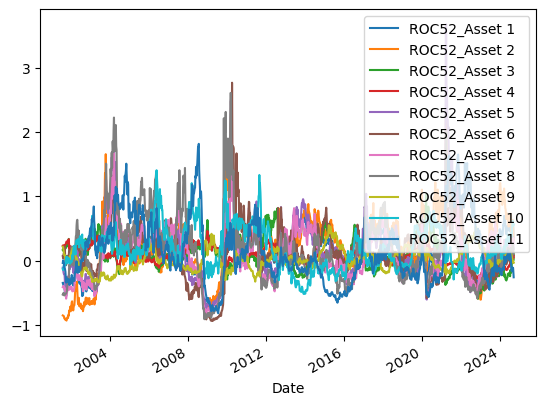

In [6]:
roc4_df = calculate_roc(weekly_rets, period=4)
roc6_df = calculate_roc(weekly_rets, period=6)
roc12_df = calculate_roc(weekly_rets, period=12)
roc26_df = calculate_roc(weekly_rets, period=26)
roc52_df = calculate_roc(weekly_rets, period=52)

roc4_df.to_excel(data_path + '/broad_assets_roc_4w.xlsx', sheet_name='broad_assets_roc4')
roc6_df.to_excel(data_path + '/broad_assets_roc_6w.xlsx', sheet_name='broad_assets_roc6')
roc12_df.to_excel(data_path + '/broad_assets_roc_12w.xlsx', sheet_name='broad_assets_roc12')
roc26_df.to_excel(data_path + '/broad_assets_roc_26w.xlsx', sheet_name='broad_assets_roc26')
roc52_df.to_excel(data_path + '/broad_assets_roc_52w.xlsx', sheet_name='broad_assets_roc52')

roc52_df.plot()

In [7]:
macd_df = calculate_macd(broad_assets, asset_columns)
macd_df.to_excel(data_path + '/broad_assets_macd.xlsx', sheet_name='broad_assets_macd')
display(macd_df)

,MACD_Line_Asset 1,Signal_Line_Asset 1,MACD_Histogram_Asset 1,MACD_Line_Asset 2,Signal_Line_Asset 2,MACD_Histogram_Asset 2,MACD_Line_Asset 3,Signal_Line_Asset 3,MACD_Histogram_Asset 3,MACD_Line_Asset 4,...,MACD_Histogram_Asset 8,MACD_Line_Asset 9,Signal_Line_Asset 9,MACD_Histogram_Asset 9,MACD_Line_Asset 10,Signal_Line_Asset 10,MACD_Histogram_Asset 10,MACD_Line_Asset 11,Signal_Line_Asset 11,MACD_Histogram_Asset 11
Date,,,,,,,,,,,,,,,,,,,,,
2000-07-31,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2000-08-01,-0.0004,-0.0001,-0.0003,-0.0100,-0.0020,-0.0080,0.0008,0.0002,0.0006,0.0004,...,0.0005,0.0010,0.0002,0.0008,0.0007,0.0001,0.0006,0.0037,0.0007,0.0030
2000-08-02,-0.0015,-0.0004,-0.0011,-0.0151,-0.0046,-0.0105,0.0009,0.0003,0.0006,0.0006,...,0.0002,0.0018,0.0005,0.0013,0.0013,0.0004,0.0009,0.0069,0.0020,0.0049
2000-08-03,-0.0008,-0.0005,-0.0004,-0.0115,-0.0060,-0.0055,0.0015,0.0005,0.0009,0.0006,...,-0.0006,0.0021,0.0008,0.0013,-0.0004,0.0002,-0.0006,0.0084,0.0033,0.0051
2000-08-04,-0.0007,-0.0005,-0.0002,-0.0149,-0.0078,-0.0071,0.0018,0.0008,0.0010,0.0009,...,-0.0003,0.0017,0.0010,0.0007,0.0000,0.0002,-0.0001,0.0115,0.0049,0.0066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,0.0011,0.0012,-0.0002,0.0007,0.0010,-0.0003,-0.0030,-0.0014,-0.0016,-0.0011,...,-0.0010,0.0015,0.0001,0.0014,-0.0015,-0.0000,-0.0015,-0.0003,0.0011,-0.0014
2024-09-03,-0.0027,0.0004,-0.0032,-0.0046,-0.0001,-0.0045,-0.0007,-0.0013,0.0005,-0.0003,...,-0.0034,0.0015,0.0004,0.0012,-0.0021,-0.0004,-0.0017,-0.0033,0.0002,-0.0035
2024-09-04,-0.0026,-0.0002,-0.0024,-0.0040,-0.0009,-0.0031,0.0013,-0.0008,0.0020,0.0004,...,-0.0022,0.0006,0.0004,0.0002,-0.0017,-0.0007,-0.0010,-0.0039,-0.0006,-0.0033


## Relative Strength Index

In [8]:
rsi_df = calculate_rsi(broad_assets)
rsi_df.to_excel(data_path + '/broad_assets_rsi.xlsx', sheet_name='broad_assets_rsi')
display(rsi_df)

,rsi_Asset 1,rsi_Asset 2,rsi_Asset 3,rsi_Asset 4,rsi_Asset 5,rsi_Asset 6,rsi_Asset 7,rsi_Asset 8,rsi_Asset 9,rsi_Asset 10,...,stoch_rsi_Asset 2,stoch_rsi_Asset 3,stoch_rsi_Asset 4,stoch_rsi_Asset 5,stoch_rsi_Asset 6,stoch_rsi_Asset 7,stoch_rsi_Asset 8,stoch_rsi_Asset 9,stoch_rsi_Asset 10,stoch_rsi_Asset 11
Date,,,,,,,,,,,,,,,,,,,,,
2000-09-06,55.1712,58.4322,60.1287,68.7115,81.9206,32.6576,45.0981,16.3601,76.9179,41.4333,...,0.0000,0.5547,0.8624,0.7024,0.4091,0.0000,0.0000,1.0000,0.2343,1.0000
2000-09-07,52.4533,58.6063,53.6639,63.9884,83.1005,37.2869,47.9909,10.4006,73.8223,38.6543,...,0.0053,0.2675,0.6862,0.7508,0.6821,0.0845,0.0000,0.8614,0.0898,1.0000
2000-09-08,50.6068,50.6003,53.2867,62.9375,71.0103,53.7270,41.9443,11.5279,72.9772,39.1461,...,0.0000,0.2712,0.6470,0.1682,1.0000,0.0000,0.0222,0.8236,0.1154,0.2458
2000-09-11,44.2404,43.5530,51.2382,59.8703,68.3738,61.0123,40.8235,9.9678,74.8015,43.5271,...,0.0000,0.1728,0.5327,0.0474,1.0000,0.0000,0.0000,0.9052,0.3432,0.4348
2000-09-12,41.8010,41.6576,48.5357,58.9714,65.8520,61.6036,45.1154,3.9405,71.8178,46.3391,...,0.0000,0.0429,0.4991,0.0000,1.0000,0.1115,0.0000,0.7717,0.4391,0.4206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,78.7291,69.3493,47.7420,47.7011,73.8547,84.3884,87.6233,62.2562,38.6038,56.2833,...,0.6320,0.0729,0.1892,1.0000,0.9775,0.9121,0.3188,1.0000,0.0000,0.0635
2024-09-03,58.6562,49.2948,51.6204,48.3940,57.8887,82.6311,68.0046,48.0550,44.3754,55.6275,...,0.0000,0.2123,0.2097,0.5829,0.9177,0.4005,0.0000,1.0000,0.0000,0.0000
2024-09-04,56.0944,48.3673,53.3142,53.1800,59.0324,82.2836,64.0768,50.2767,40.7798,60.8648,...,0.0000,0.3790,0.5222,0.5883,0.9059,0.2992,0.0686,0.8607,0.2423,0.0000


## Bollinger Bands

In [9]:
bb20_df = calculate_bollinger_bands(broad_assets, window=20)
bb90_df = calculate_bollinger_bands(broad_assets, window=90)
bb180_df = calculate_bollinger_bands(broad_assets, window=180)
bb240_df = calculate_bollinger_bands(broad_assets, window=240)

bb20_df.to_excel(data_path + '/broad_assets_bb_20d.xlsx', sheet_name='broad_assets_bb20')
bb90_df.to_excel(data_path + '/broad_assets_bb_90d.xlsx', sheet_name='broad_assets_bb90')
bb180_df.to_excel(data_path + '/broad_assets_bb_180d.xlsx', sheet_name='broad_assets_bb180')
bb240_df.to_excel(data_path + '/broad_assets_bb_240d.xlsx', sheet_name='broad_assets_bb240')

display(bb240_df)

,sma240_Asset 1,sma240_Asset 2,sma240_Asset 3,sma240_Asset 4,sma240_Asset 5,sma240_Asset 6,sma240_Asset 7,sma240_Asset 8,sma240_Asset 9,sma240_Asset 10,...,lower240_Asset 2,lower240_Asset 3,lower240_Asset 4,lower240_Asset 5,lower240_Asset 6,lower240_Asset 7,lower240_Asset 8,lower240_Asset 9,lower240_Asset 10,lower240_Asset 11
Date,,,,,,,,,,,,,,,,,,,,,
2001-07-12,-0.0013,-0.0045,0.0006,0.0008,0.0001,0.0004,-0.0019,-0.0027,0.0010,-0.0005,...,-0.1586,-0.0206,-0.0135,-0.0631,-0.0278,-0.0555,-0.0462,-0.0218,-0.0331,-0.0414
2001-07-13,-0.0013,-0.0048,0.0006,0.0008,-0.0000,0.0004,-0.0020,-0.0028,0.0010,-0.0005,...,-0.1586,-0.0206,-0.0135,-0.0630,-0.0278,-0.0554,-0.0462,-0.0218,-0.0330,-0.0413
2001-07-16,-0.0014,-0.0049,0.0006,0.0008,-0.0001,0.0002,-0.0019,-0.0029,0.0010,-0.0005,...,-0.1589,-0.0206,-0.0135,-0.0631,-0.0275,-0.0552,-0.0464,-0.0218,-0.0330,-0.0414
2001-07-17,-0.0013,-0.0046,0.0006,0.0008,-0.0000,0.0003,-0.0020,-0.0029,0.0009,-0.0004,...,-0.1587,-0.0206,-0.0135,-0.0631,-0.0274,-0.0553,-0.0464,-0.0218,-0.0330,-0.0414
2001-07-18,-0.0015,-0.0052,0.0007,0.0008,-0.0001,0.0004,-0.0018,-0.0029,0.0008,-0.0003,...,-0.1593,-0.0207,-0.0136,-0.0633,-0.0272,-0.0551,-0.0464,-0.0222,-0.0327,-0.0418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,0.0019,0.0021,0.0003,0.0003,0.0017,0.0016,0.0015,0.0009,-0.0001,0.0020,...,-0.0423,-0.0410,-0.0166,-0.0520,-0.0454,-0.0312,-0.0355,-0.0151,-0.0349,-0.0355
2024-09-03,0.0018,0.0018,0.0005,0.0003,0.0014,0.0017,0.0013,0.0008,-0.0001,0.0020,...,-0.0433,-0.0409,-0.0166,-0.0528,-0.0453,-0.0317,-0.0359,-0.0151,-0.0349,-0.0360
2024-09-04,0.0018,0.0019,0.0005,0.0003,0.0015,0.0017,0.0013,0.0009,-0.0002,0.0020,...,-0.0430,-0.0409,-0.0166,-0.0527,-0.0453,-0.0318,-0.0359,-0.0152,-0.0349,-0.0361


## EWMA Volatility

<Axes: xlabel='Date'>

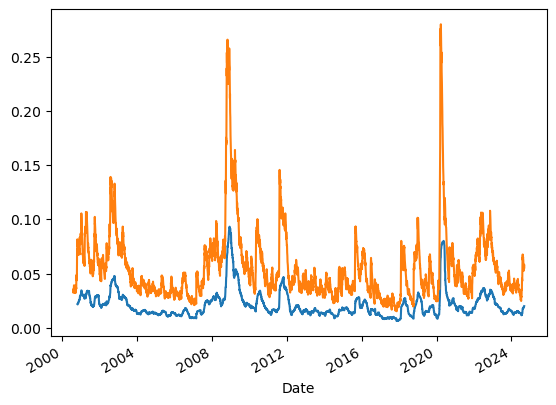

In [12]:
ewma_vol = calc_ewma_volatility(broad_assets, return_columns=asset_columns) * np.sqrt(7)    # scaling daily EWMA vol up to weekly
rolling_vol_20 = broad_assets.rolling(window=20).std()
rolling_vol_60 = broad_assets.rolling(window=60).std()
rolling_vol_126 = broad_assets.rolling(window=126).std()
rolling_vol_252 = broad_assets.rolling(window=252).std()
rolling_vol_504 = broad_assets.rolling(window=504).std()

ewma_vol.to_excel(data_path + '/broad_assets_ewma_vol.xlsx', sheet_name='broad_assets_ewma_vol')
rolling_vol_20.to_excel(data_path + '/broad_assets_rolling_vol_20.xlsx', sheet_name='broad_assets_rolling_vol_20')
rolling_vol_60.to_excel(data_path + '/broad_assets_rolling_vol_60.xlsx', sheet_name='broad_assets_rolling_vol_60')
rolling_vol_126.to_excel(data_path + '/broad_assets_rolling_vol_126.xlsx', sheet_name='broad_assets_rolling_vol_126')
rolling_vol_252.to_excel(data_path + '/broad_assets_rolling_vol_252.xlsx', sheet_name='broad_assets_rolling_vol_252')
rolling_vol_504.to_excel(data_path + '/broad_assets_rolling_vol_504.xlsx', sheet_name='broad_assets_rolling_vol_504')

rolling_vol_60['Asset 1'].plot()
ewma_vol.iloc[:, 0].plot()

## Skew & Kurtosis

In [11]:
# broad_assets = broad_assets.drop(columns=['weekday', 'trading_day', 'week'])

In [13]:
skew_daily = broad_assets.expanding(min_periods=(252*2)).skew().dropna()
rolling_skew_20 = broad_assets.rolling(window=20).skew()
rolling_skew_60 = broad_assets.rolling(window=60).skew()
rolling_skew_126 = broad_assets.rolling(window=126).skew()
rolling_skew_252 = broad_assets.rolling(window=252).skew()
rolling_skew_504 = broad_assets.rolling(window=504).skew()

skew_daily.to_excel(data_path + '/broad_assets_skew.xlsx', sheet_name='broad_assets_skew')
rolling_skew_20.to_excel(data_path + '/broad_assets_rolling_skew_20.xlsx', sheet_name='broad_assets_rolling_skew_20')
rolling_skew_60.to_excel(data_path + '/broad_assets_rolling_skew_60.xlsx', sheet_name='broad_assets_rolling_skew_60')
rolling_skew_126.to_excel(data_path + '/broad_assets_rolling_skew_126.xlsx', sheet_name='broad_assets_rolling_skew_126')
rolling_skew_252.to_excel(data_path + '/broad_assets_rolling_skew_252.xlsx', sheet_name='broad_assets_rolling_skew_252')
rolling_skew_504.to_excel(data_path + '/broad_assets_rolling_skew_504.xlsx', sheet_name='broad_assets_rolling_skew_504')

display(skew_daily)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2002-08-05,0.3346,0.7197,-0.5689,-0.3723,0.1986,0.1400,0.1524,-0.2544,0.0467,1.3809,-0.3320
2002-08-06,0.3386,0.7137,-0.5644,-0.3771,0.2116,0.1365,0.1634,-0.2519,0.0595,1.3836,-0.3353
2002-08-07,0.3345,0.7102,-0.5672,-0.3779,0.2089,0.1400,0.1624,-0.2389,0.0618,1.3833,-0.3313
2002-08-08,0.3422,0.7049,-0.5628,-0.3733,0.2044,0.1407,0.1619,-0.2411,0.0582,1.3809,-0.3316
2002-08-09,0.3406,0.7069,-0.5411,-0.3631,0.2059,0.1420,0.1603,-0.2438,0.0619,1.3710,-0.3348
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,-0.1586,0.2995,-0.0532,0.0497,-0.2987,0.1936,-0.2546,0.5143,0.0126,-0.1788,-0.3271
2024-09-03,-0.1585,0.2990,-0.0535,0.0494,-0.2988,0.1936,-0.2542,0.5145,0.0124,-0.1787,-0.3268
2024-09-04,-0.1585,0.2991,-0.0536,0.0490,-0.2988,0.1936,-0.2542,0.5145,0.0127,-0.1787,-0.3265


In [14]:
kurtosis_daily = broad_assets.expanding(min_periods=(252*2)).kurt().dropna()
rolling_kurt_20 = broad_assets.rolling(window=20).kurt()
rolling_kurt_60 = broad_assets.rolling(window=60).kurt()
rolling_kurt_126 = broad_assets.rolling(window=126).kurt()
rolling_kurt_252 = broad_assets.rolling(window=252).kurt()
rolling_kurt_504 = broad_assets.rolling(window=504).kurt()

kurtosis_daily.to_excel(data_path + '/broad_assets_kurtosis.xlsx', sheet_name='broad_assets_kurtosis')
rolling_kurt_20.to_excel(data_path + '/broad_assets_rolling_kurt_20.xlsx', sheet_name='broad_assets_rolling_kurt_20')
rolling_kurt_60.to_excel(data_path + '/broad_assets_rolling_kurt_60.xlsx', sheet_name='broad_assets_rolling_kurt_60')
rolling_kurt_126.to_excel(data_path + '/broad_assets_rolling_kurt_126.xlsx', sheet_name='broad_assets_rolling_kurt_126')
rolling_kurt_252.to_excel(data_path + '/broad_assets_rolling_kurt_252.xlsx', sheet_name='broad_assets_rolling_kurt_252')
rolling_kurt_504.to_excel(data_path + '/broad_assets_rolling_kurt_504.xlsx', sheet_name='broad_assets_rolling_kurt_504')

display(kurtosis_daily)

,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2002-08-05,1.6640,2.4623,0.8770,1.9608,0.5218,3.7164,2.9311,1.1800,0.7778,9.9041,1.3716
2002-08-06,1.6248,2.4197,0.8488,1.9157,0.5161,3.7170,2.8709,1.1836,0.7650,9.9112,1.3673
2002-08-07,1.5983,2.4183,0.8475,1.8983,0.5188,3.6515,2.8275,1.1637,0.7506,9.6121,1.3638
2002-08-08,1.5625,2.4043,0.8420,1.8718,0.5093,3.6644,2.7829,1.1515,0.7379,9.5711,1.3724
2002-08-09,1.5688,2.4150,0.8383,1.8415,0.5159,3.6290,2.7919,1.1569,0.7370,9.4825,1.3765
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,10.5420,8.3634,3.5281,3.5009,6.1780,21.3281,9.2950,18.8917,1.6137,5.8156,3.1936
2024-09-03,10.5318,8.3541,3.5258,3.5000,6.1693,21.3321,9.2899,18.8855,1.6144,5.8164,3.1898
2024-09-04,10.5339,8.3559,3.5229,3.4981,6.1707,21.3360,9.2917,18.8891,1.6140,5.8179,3.1894


## Hilbert Transform

In [15]:
ht_transforms = calc_hilbert(broad_assets)
ht_transforms.to_excel(data_path + '/broad_assets_ht_transforms.xlsx', sheet_name='broad_assets_ht_transforms')
display(ht_transforms)

,ht_dcperiod_Asset 1,ht_dcphase_Asset 1,inphase_Asset 1,sine_Asset 1,ht_trendmode_Asset 1,ht_dcperiod_Asset 2,ht_dcphase_Asset 2,inphase_Asset 2,sine_Asset 2,ht_trendmode_Asset 2,...,ht_dcperiod_Asset 10,ht_dcphase_Asset 10,inphase_Asset 10,sine_Asset 10,ht_trendmode_Asset 10,ht_dcperiod_Asset 11,ht_dcphase_Asset 11,inphase_Asset 11,sine_Asset 11,ht_trendmode_Asset 11
Date,,,,,,,,,,,,,,,,,,,,,
2000-10-27,22.9056,47.6367,0.0517,0.7389,1,36.7185,76.1162,0.1905,0.9708,1,...,16.1676,1.5350,-0.0049,0.0268,1,24.6703,277.7182,-0.0414,-0.9909,1
2000-10-30,22.2560,57.6243,0.0469,0.8446,1,35.4042,84.7961,0.1524,0.9959,1,...,15.7801,-10.7813,-0.0058,-0.1871,1,23.8106,292.2189,0.0103,-0.9257,1
2000-10-31,21.7633,70.5136,0.0343,0.9427,1,33.8106,98.3836,0.0491,0.9893,1,...,15.4657,-23.4220,-0.0081,-0.3975,1,22.8284,312.1748,0.0099,-0.7411,1
2000-11-01,21.2824,86.0630,-0.0079,0.9976,1,32.0770,233.2873,-0.1430,-0.8016,1,...,15.3363,-22.4791,-0.0181,-0.3823,1,22.0150,-28.9100,-0.0197,-0.4834,1
2000-11-02,20.8243,115.1626,-0.0364,0.9051,1,30.4675,268.6779,-0.2188,-0.9997,0,...,15.4506,-20.7384,-0.0309,-0.3541,1,21.4205,-19.5496,-0.0266,-0.3346,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,19.7883,204.5312,0.0469,-0.4152,1,21.5685,194.5359,-0.0556,-0.2510,1,...,16.9015,216.3518,-0.0608,-0.5927,1,20.9577,239.7560,0.0156,-0.8639,0
2024-09-03,19.9034,214.8091,0.0812,-0.5708,1,21.3596,218.4876,-0.0658,-0.6223,0,...,17.9949,220.1810,0.1725,-0.6452,1,20.0412,286.0399,0.0794,-0.9611,1
2024-09-04,20.0680,224.4063,0.0320,-0.6997,1,21.2081,232.1717,-0.1026,-0.7899,0,...,18.9384,224.6277,0.2388,-0.7025,1,19.3261,-31.1397,0.0812,-0.5171,1
